In [1]:
import cv2
import numpy as np

from google.colab.patches import cv2_imshow

In [2]:
def get_mean_and_std(x):
	x_mean, x_std = cv2.meanStdDev(x)
	x_mean = np.hstack(np.around(x_mean,2))
	x_std = np.hstack(np.around(x_std,2))
	return x_mean, x_std

In [3]:
def scale_img(source_img, target_img):
  '''
  Reinhard Method Applying
  '''
  src = cv2.cvtColor(source_img, cv2.COLOR_BGR2LAB)
  trg = cv2.cvtColor(target_img, cv2.COLOR_BGR2LAB)

  source_l, source_a, source_b = cv2.split(src)
  target_l, target_a, target_b = cv2.split(trg)

  source_means, source_stds = get_mean_and_std(src)
  target_means, target_stds = get_mean_and_std(trg)

  source_l = source_l - source_means[0]
  source_a = source_a - source_means[1]
  source_b = source_b - source_means[2]

  new_l = source_l *  target_stds[0] / source_stds[0]  + target_means[0]
  new_a = source_a *  target_stds[1] / source_stds[1]  + target_means[1]
  new_b = source_b *  target_stds[2] / source_stds[2]  + target_means[2]

  # preventing that some pixels exceed the limit
  new_l[new_l < 0] = 0
  new_l[new_l > 255] = 255

  new_a[new_a < 0] = 0
  new_a[new_a > 255] = 255

  new_b[new_b < 0] = 0
  new_b[new_b > 255] = 255

  scaled_img = cv2.merge([new_l, new_a, new_b])
  scaled_img = np.array(scaled_img, dtype=np.uint8)
  return scaled_img

In [4]:
src_img = cv2.imread('in_01.png')
trg_img = cv2.imread('tar_01.png')

new_img = scale_img(src_img, trg_img)

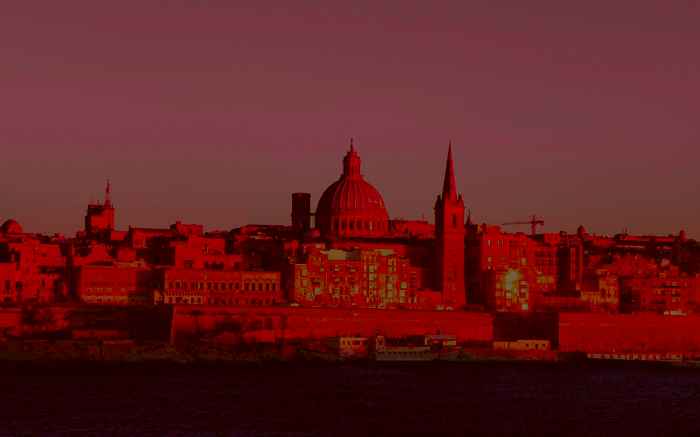

In [5]:
cv2_imshow(cv2.cvtColor(new_img, cv2.COLOR_LAB2BGR))

### PART 2

In [6]:
i = cv2.imread('in_11.png')

In [7]:
i.shape

(700, 530, 3)

In [8]:
i = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)

In [9]:
def score(img1, img2):
    '''
    returns the matching score of images with NCC method
    '''
    img1 = np.ndarray.flatten(img1)
    img2 = np.ndarray.flatten(img2)
    return np.round(np.dot(img1 / np.linalg.norm(img1), img2 / np.linalg.norm(img2)), 3)

In [10]:
import math
def adjust_img(img, step):
  '''
  Adjust the dimensions of an image by scale size.
  For example if scale equals to 5 then axes becomes multiple of 5.
  Returns adjusted image.
  '''
  height = img.shape[0]
  width = img.shape[1]

  if height % step != 0:
    height = height // step * step
  if width % step != 0:
    width = width // step * step

  return img[:height, :width]

In [11]:
def get_new_height_width(img, step):
  '''
  Returns the height and width of adjusted img
  '''
  img = adjust_img(img, step)
  height = img.shape[0]
  width = img.shape[1]
  return height, width

In [12]:
def find_matches(src, trg):
  '''
  Returns indices of best matching pairs
  For instance if you get (0,1), (2,3) then src[0:5, 5:10] and trg[10:15, 15:20] (if scale is 5 pixel)
  '''
  steps = [25, 49, 100]
  matches = {}
  for step in steps:

    src = adjust_img(src, step)
    trg = adjust_img(trg, step)

    source_hs = list(range(0, src.shape[0] + 1, step))
    source_ws = list(range(0, src.shape[1] + 1, step))

    target_hs = list(range(0, trg.shape[0] + 1, step))
    target_ws = list(range(0, trg.shape[1] + 1, step))

    src_indices = []
    trg_indices = []

    for idx in range(len(source_hs) - 1):

      for inner_idx in range(len(source_ws) - 1):

        temp_src = src[source_hs[idx]: source_hs[idx + 1], source_ws[inner_idx]: source_ws[inner_idx + 1]]
        result = 0

        best_idx_h = -1
        best_idx_w = -1

        for idx2 in range(len(target_hs) - 1):

          for inner_idx_2 in range(len(target_ws) - 1):
            
            temp_trg = src[target_hs[idx2]: target_hs[idx2 + 1], target_ws[inner_idx_2]: target_ws[inner_idx_2 + 1]]

            scr = score(temp_src, temp_trg)
            if scr > result:
              result = scr


              best_idx_h = idx2
              best_idx_w = inner_idx_2

        src_square_number = (idx, inner_idx)
        trg_square_number = (best_idx_h, best_idx_w)

        src_indices.append(src_square_number)
        trg_indices.append(trg_square_number)

    matches[step] = list(zip(src_indices, trg_indices))

  return matches

In [13]:
def partial_color_transfer(src, trg, filename):
  '''
  Write the final image after scaling
  '''

  # create a copy instead creating a new matrix etc
  canvas = src.copy()

  matches = find_matches(src, trg)

  for step, match in matches.items():

    for values in match:

      src_info, trg_info = values

      src_height_idx, src_width_idx = src_info
      trg_height_idx, trg_width_idx = trg_info

      '''
      In above I mention 'For instance if you get (0,1), (2,3) then src[0:5, 5:10] and trg[10:15, 15:20] (if scale is 5 pixel)'
      In here that transformation is applying. 
      '''
      src_height_starting_idx = src_height_idx * step
      src_height_ending_idx = src_height_starting_idx + step
      trg_height_starting_idx = trg_height_idx * step
      trg_height_ending_idx = trg_height_idx * step + step  

      src_width_starting_idx = src_width_idx * step
      src_width_ending_idx = src_width_starting_idx + step
      trg_width_starting_idx = trg_width_idx * step
      trg_width_ending_idx = trg_width_starting_idx + step

      canvas[src_height_starting_idx:src_height_ending_idx, src_width_starting_idx:src_width_ending_idx, :] = scale_img(src[src_height_starting_idx:src_height_ending_idx, src_width_starting_idx:src_width_ending_idx, :], trg[trg_height_starting_idx:trg_height_ending_idx, trg_width_starting_idx:trg_width_ending_idx, :])
    
    result_filename = filename + str(step) + '.png'
    cv2.imwrite(result_filename, cv2.cvtColor(canvas, cv2.COLOR_LAB2BGR))

In [14]:
import os
src_files = sorted([filename for filename in os.listdir() if filename.startswith('in')])
trg_files = sorted([filename for filename in os.listdir() if filename.startswith('tar')])

In [15]:
def create_part_1_results(src_files, trg_files):
  '''
  Writing color transferred images using classic Reinhard
  '''
  size = len(src_files)
  filename = 'part_1_results'
  if not os.path.exists(filename):
    os.mkdir(filename)

  for i in range(size):

    src_file = src_files[i]
    trg_file = trg_files[i]

    src_img = cv2.imread(src_file)
    trg_img = cv2.imread(trg_file)

    new_img = scale_img(src_img, trg_img)

    img_filename = filename + '/' + src_file.split('.')[0] + '_result' + '.png'
    cv2.imwrite(img_filename, cv2.cvtColor(new_img, cv2.COLOR_LAB2BGR))

In [16]:
def create_part_2_results(src_files, trg_files):
  '''
  Writing color transferred images using regional Reinhard method
  '''
  size = len(src_files)
  filename = 'part_2_results'
  if not os.path.exists(filename):
    os.mkdir(filename)

  for i in range(size):

    src_file = src_files[i]
    trg_file = trg_files[i]

    src_img = cv2.imread(src_file)
    trg_img = cv2.imread(trg_file)

    img_filename = filename + '/' + src_file.split('.')[0] + '_result'
    partial_color_transfer(src_img, trg_img, img_filename)

In [17]:
create_part_1_results(src_files, trg_files)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


In [18]:
create_part_2_results(src_files, trg_files)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


In [19]:
img1 = cv2.imread('in_01.png')
img3 = cv2.imread('in_03.png')
img6 = cv2.imread('in_06.png')
img11 = cv2.imread('in_11.png')

img1_result = cv2.imread('in_01_result.png')
img3_result = cv2.imread('in_03_result.png')
img6_result = cv2.imread('in_06_result.png')
img11_result = cv2.imread('in_11_result.png')

img1_result_2 = cv2.imread('in_01_result100.png')
img3_result_2 = cv2.imread('in_03_result100.png')
img6_result_2 = cv2.imread('in_06_result100.png')
img11_result_2 = cv2.imread('in_11_result100.png')

In [20]:
import matplotlib.pyplot as plt

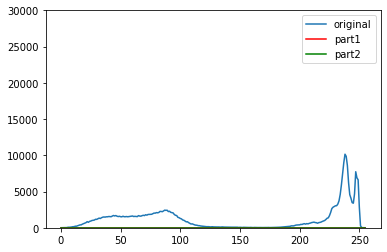

In [21]:
histr = cv2.calcHist([img1],[0],None,[256],[0,256])
histr_res = cv2.calcHist([img1_result],[0], None, [256], [0, 256])
histr_res_2 = cv2.calcHist([img1_result_2],[0], None, [256], [0, 256])
# show the plotting graph of an image
plt.ylim([0, 30000])
plt.plot(histr, label='original')
plt.plot(histr_res, color = 'red', label='part1')
plt.plot(histr_res_2, color = 'green', label='part2')
plt.legend()
plt.show()

In [21]:
# I'm going to try with vertical or horizontal shaped rectangles like 10px height and all width